# **Group Project Final Report: Predicting Subscription Status of Game-related newsletter**


## **I. Introduction**

**Background Information:**  This data was collected through the Minecraft servers ran by UBC Computer Science students. This is real data, meaning all the players are real people and all the sessions are real gaming sessions recorded. Players registered their information and the servers recorded the moment they launched the game and the second they stopped playing the game.

**Question:** In `players.csv`, can the total amount of hours played and experience predict whether a gamer will subscribe to a gaming newsletter?

Target variable: `subscribe`

Predictor variables: `played_hours` and `experience`

**Let's load the data and library**


In [35]:
library(tidyverse)
library(tidymodels)
library(janitor)
library(RColorBrewer)
library(dplyr)
library(themis)

In [36]:
sessions_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/sessions.csv")
players_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/players.csv")
players_data <- clean_names(players_data) #to make column names standard format
head(players_data)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Dataset:** We will be working with the players dataset (`players.csv`) only, and not with the sessions dataset (`sessions.csv`). Here are some details on the dataset we will be working on:
- Contains 196 observations, where each observation represents a unique player.
- This dataset represents a player; thus, name, age, and gender are included. In addition, the player's private and unique hashed email is also present along with their played hours, experience, and whether are not they are subscribed to the Minecraft server.
- 7 variables:
  + `experience` *<chr>*: Skill level of each player (Beginner, Regular, Amateur, Pro, Veteran), stored as a character data type
  + `subscribe` *<lgl>*: Whether the player is subscribed, stored as a logical data type (TRUE/FALSE)
  + `hashedEmail` *(chr)*: Unique identifier for each player, stored as a character data type
  + `played_hours` *(dbl)*: Total time (in hours) the player has spent on the server, stored as a double data type
  + `name` *(chr)*: Player's name, stored as a character data type
  + `gender` *(chr)*: Player's preferred gender (7 categories), represented as a character data type
  + `Age` *(dbl)*: Player's age (8 to 50 years), stored as a double data type

**Potential Issues:**
- `experience` should be a categorical data type instead of a character (chr). This would help in visualization, data intepretation, and generating more accurate and effective summary statistics.
- `gender` should also be categorical for the same reason.
- All numerical data (`played_hours` and `age`) must be standardized if they are to be used in prediction. This is because unstandardized data could cause issues and disproportionately influence k-nearest neighbor or other predictive models, reducing accuracy and lread to incorrect predictions.
- Some `age` values are missing, potentially causing problems with data analysis.
- Some values in `played_hours` are zero. The zero values suggest issues with obtaining the data. This may require finding a way to work around it and can imply how other values may not be accurate.

## **II. Methods & Results**

**Loading the datasets**

In [37]:
players_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/players.csv")
sessions_data <- read_csv("https://raw.githubusercontent.com/duybau2006/Data-Science-100-Group-Project/refs/heads/main/sessions.csv")

head(players_data)
head(sessions_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


**Wrangling and cleaning the needed dataset**

Here, we changed the data types of each variable:
- `experience`: from *chr* to *fct*
- `gender`: from *chr* to *fct*
- `subscribe`: from *lgl* to *fct*

We also changed the values inside the variable `subscribe` for better visualizations:
- **TRUE** to **Yes**
- **FALSE** to **No**

**Initial split**: to be done before exploratory data analysis to look at training data only, so the model does not see the whole dataset and become influenced/biased.

In [38]:
set.seed(7283)

#tidying data first
players_tidy <- players_data |>
mutate(experience = as_factor(experience),
       gender = as_factor(gender),
       subscribe = as_factor(subscribe),
       subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))

#performing initial_split 
players_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

glimpse(players_train)
glimpse(players_test)

Rows: 147
Columns: 7
$ experience   <fct> Veteran, Amateur, Amateur, Amateur, Veteran, Veteran, Ama…
$ subscribe    <fct> No, No, No, No, No, No, No, No, No, No, No, No, No, No, N…
$ hashedEmail  <chr> "b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118e…
$ played_hours <dbl> 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 1.4, 0.0, 0.0, 0.0, 0.…
$ name         <chr> "Blake", "Emerson", "Quinlan", "Anastasia", "Finn", "Vivi…
$ gender       <fct> Male, Male, Male, Female, Male, Male, Prefer not to say, …
$ Age          <dbl> 17, 21, 22, 17, 23, 18, 33, 25, 23, 42, 28, 21, 23, 17, 1…
Rows: 49
Columns: 7
$ experience   <fct> Pro, Amateur, Veteran, Beginner, Beginner, Amateur, Amate…
$ subscribe    <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, No, Yes, No,…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 0.1, 0.0, 1.0, 0.6, 0.2, 0.0, 5.6, 0.3, 0.0, 12.5, …
$ name         <chr> "Morgan", "Natalie", "Niamh", "Leah", "Jabari", "Kennedy"…

Performing **Exploratory Data Analysis** on training data

**General summary of the dataset used**

Since we are trying to predict whether a gamer will subscribe to a gaming newsletter or not using the total amount of hours played and their experience, we will only be looking into these variables: `subscribe`, `played_hours` and `experience`.
- `player_experience`: We group the data by the categories within the experience variable then find the count and proportions of each level of experience
- `player_subscribed`: We did the same thing as `player_experience` except we find how many people subscribed and how many didn't
- `all_avg_played_hours`: We calculated the mean of played hours including the zero values
- `avg_played_hours_excluding0`: We calculated the played hours mean excluding the zero values

***Findings:***
- The average total play time is around 7.31 hours when calculating including 0 values
- The average total play time when excluding 0 values is around 10.78 hours
- Most players are subscribed:
  + `Yes`: 73.47% (108 players) on training data
  + `No`: 26.53% (39 players) on training data
- The majority of players fall into the Amateur and Veteran categories, comprising over 50% of the total players. In contrast, Pro players are the least represented group in the dataset:
  + `Amateur`: 34.01% (50 players)
  + `Veteran`: 22.45% (33 players)
  + `Regular`: 21.09% (31 players)
  + `Beginner`: 16.33% (24 players)
  + `Pro`: 6.12% (9 players)
- The majority of players who subscribed were Amateur players, though this does not mean that Amateur players are most likely to subscribe because they are the highest populated group.

In [39]:
set.seed(7283)
#number of players based on experience
player_experience <- players_train |>
                group_by(experience) |>
                summarize(count = n()) |>
                mutate(percentage = count / sum(count) * 100)|>
                arrange(desc(count))
player_experience

#number of players based on whether or not they are subscribed
player_subscribed <- players_train |>
                group_by(subscribe) |>
                summarize(count = n()) |>
                mutate(percentage = count / sum(count) * 100)|>
                arrange(desc(count))
player_subscribed

#finding average played hours with 0 values
all_avg_played_hours <- players_train |>
            summarize(avg_played_hours = mean(played_hours, na.rm = TRUE))
all_avg_played_hours

#finding average played hours overall excluding 0 values
avg_played_hours_excluding0 <- players_train |>
            filter(played_hours != 0) |>
            summarize(avg_played_hours_overall = mean(played_hours))
avg_played_hours_excluding0

experience,count,percentage
<fct>,<int>,<dbl>
Amateur,50,34.013605
Veteran,33,22.448980
Regular,31,21.088435
Beginner,24,16.326531
Pro,9,6.122449


subscribe,count,percentage
<fct>,<int>,<dbl>
Yes,108,73.46939
No,39,26.53061


avg_played_hours
<dbl>
7.311565


avg_played_hours_overall
<dbl>
13.77949


**Visualization of the datasets**

Here, we decided to set up the bar graphs for:
- Number of players based on the level of experience
- Number of players based on whether they are subscribed or not
- Number of players who are subscribed based on their level of experience

This helps us visualize the data better and see how well subscription status is connected to the level of experience to answer our initial question much easier.

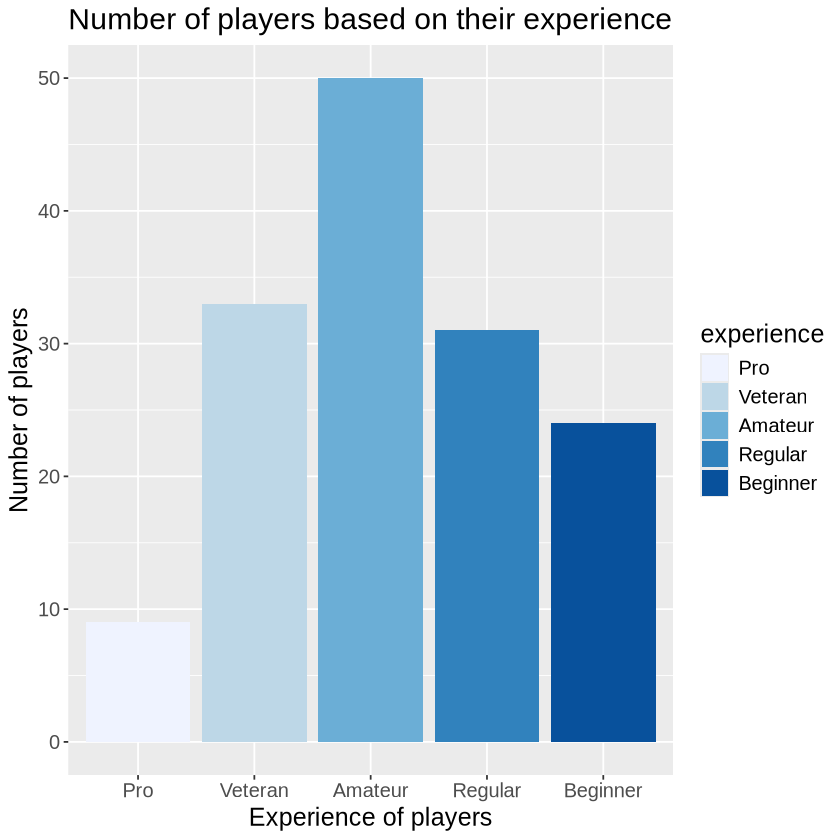

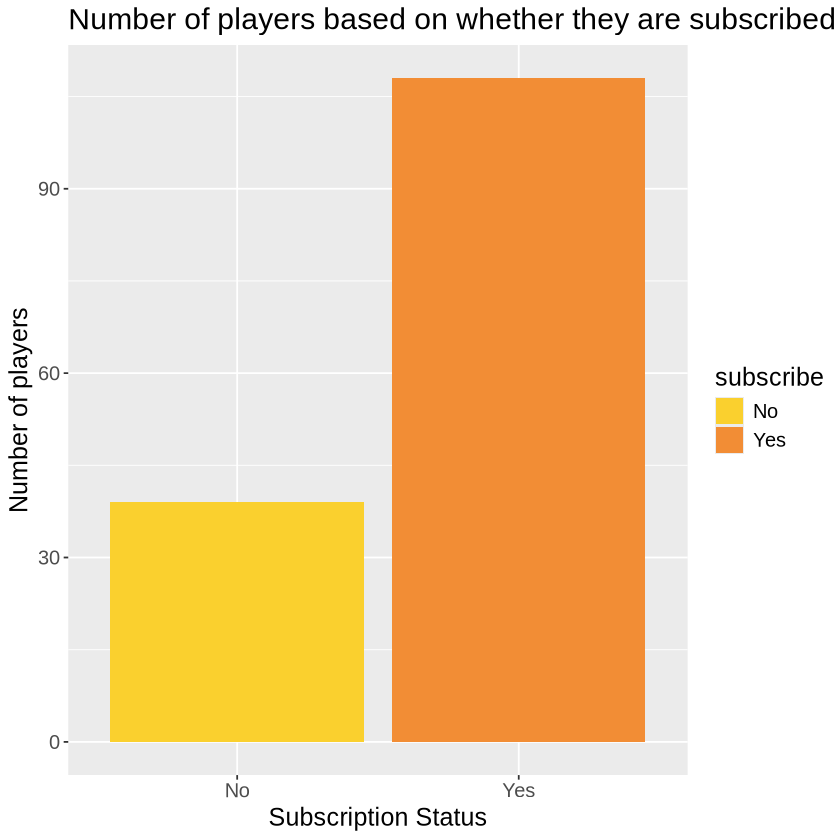

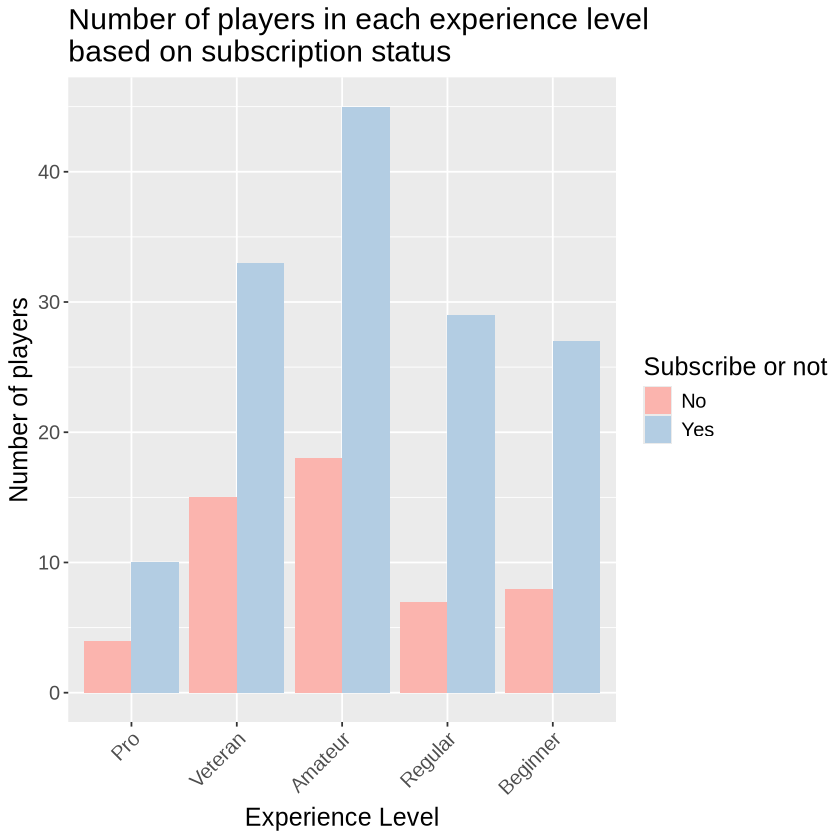

In [40]:
#Bar graph of the level of experience of players
player_experience_plot <- player_experience |>
    ggplot(aes(x = experience, y = count, fill = experience)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Experience of players", 
         y = "Number of players") +
    ggtitle("Number of players based on their experience") +
    scale_fill_brewer(palette = "Blues") +
    theme(text = element_text(size = 15))
player_experience_plot

#Bar graph of the subscription of players
player_subscribe_plot <- player_subscribed |>
    ggplot(aes(x = subscribe, y = count, fill = fct_reorder(subscribe, count))) + 
    geom_bar(stat = "identity") + 
    labs(x = "Subscription Status", 
         y = "Number of players",
        fill = "subscribe") +
    ggtitle("Number of players based on whether they are subscribed or not") +
    scale_fill_manual(values = c("No" = "#FAD02E", "Yes" = "#F28D35")) + 
    theme(text = element_text(size = 15))
player_subscribe_plot

#Bar graph of proportions of each level of experience that subscribed and not
player_subscribe_experience <- ggplot(players_tidy, aes(x= experience, fill = subscribe)) + 
    geom_bar(position = "dodge") +  
    labs(x = "Experience Level", 
         y = "Number of players",
         fill = "Subscribe or not") +
    ggtitle("Number of players in each experience level\nbased on subscription status") +  
    scale_fill_brewer(palette = "Pastel1") +
    theme(text = element_text(size = 15), axis.text.x = element_text(angle = 45, hjust = 1)) 
player_subscribe_experience

**Data analysis**

***Assess accuracy***

Since we are trying to predict a category, we must use the KNN-classification model. Our plan is to pick a model with the highest accuracy:
- Done previously: Split the players' data set into two different sets and utilize strata = subscribe to ensure that the training and testing subsets contain the right proportions of each category of observation:
  + 75% will be the training set
  + 25% will be the testing set
- Next, preprocessing will be performed only on `players_train`, so the model would not be influenced by the test data in model training and we want to test the model on unseen data (Timbers et al., 2024, Chapter 6). We standardize the variables for our recipe which is essential for KNN because it is distance-based. We also ensure unsampling is skipped when using the test data.
- Imputation step is also added to deal with the missing/unrecorded entries (Timbers et al., 2024, Chapter 5). We included all players' observations, because while some players have zero hours recorded, their subscription status is informative.
- Since we want to know which k-value is best for our model, we used cross-validation and have 5 different folds.
- We created a tibble of k values between 1 and 49 (odd numbers), and collected the accuracy for each.
- Then we sort by the highest mean accuracy from cross-validation and extract the best neighbors to use for our model.

In [41]:
set.seed(1234)
#preprocessing the training data
players_recipe <- recipe(subscribe ~ experience + played_hours,
                        data = players_train) |>
  step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
  step_impute_mean(played_hours) |>  #imputation for the zero values
  step_scale(played_hours) |>
  step_center(played_hours)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4977176,5,0.03481138,Preprocessor1_Model01
2,accuracy,binary,0.4562890,5,0.03306758,Preprocessor1_Model02
3,accuracy,binary,0.4362890,5,0.03874015,Preprocessor1_Model03
4,accuracy,binary,0.4362890,5,0.03874015,Preprocessor1_Model04
5,accuracy,binary,0.4634319,5,0.03233410,Preprocessor1_Model05
6,accuracy,binary,0.4500985,5,0.03623282,Preprocessor1_Model06
7,accuracy,binary,0.5041544,5,0.03116100,Preprocessor1_Model07
8,accuracy,binary,0.5041544,5,0.03116100,Preprocessor1_Model08
9,accuracy,binary,0.4979639,5,0.03725366,Preprocessor1_Model09


[1] 7

***Fitting the highest accuracy k onto our testing set***
- Here, we found the best k value (k = 7) and fit it on the training data, creating a model that we can use
- Then we use this model to make predictions on the test dataset and evaluate the accuracy of it

In [42]:
set.seed(1234)
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit_best <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec_best) |>
  fit(data = players_train)

knn_fit_best

players_test_predictions <- predict(knn_fit_best, players_test) |>
  bind_cols(players_test)

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_upsample()
• step_impute_mean()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4027778
Best kernel: rectangular
Best k: 7

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.3877551


The confusion matrix is the **following**: This helps us evaluate the performance of our classification model

In [43]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction No Yes
       No  11  28
       Yes  2   8

**Visualization of the analysis:**

We choose to visualize two important graphs:
- A line graph showing different values of k and the accuracy that each model with the respective k has. It allows us to see which value of k has the highest accuracy
- A bar graph comparing prediction distributions, it allow us to see whether we are overpredicting or underpredicting a certain class

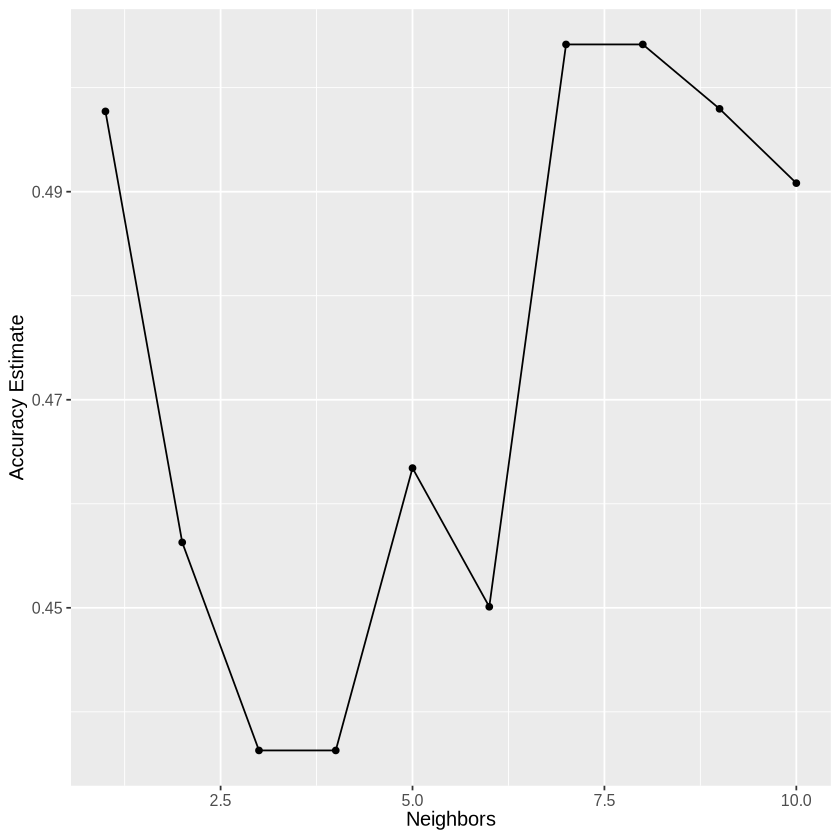

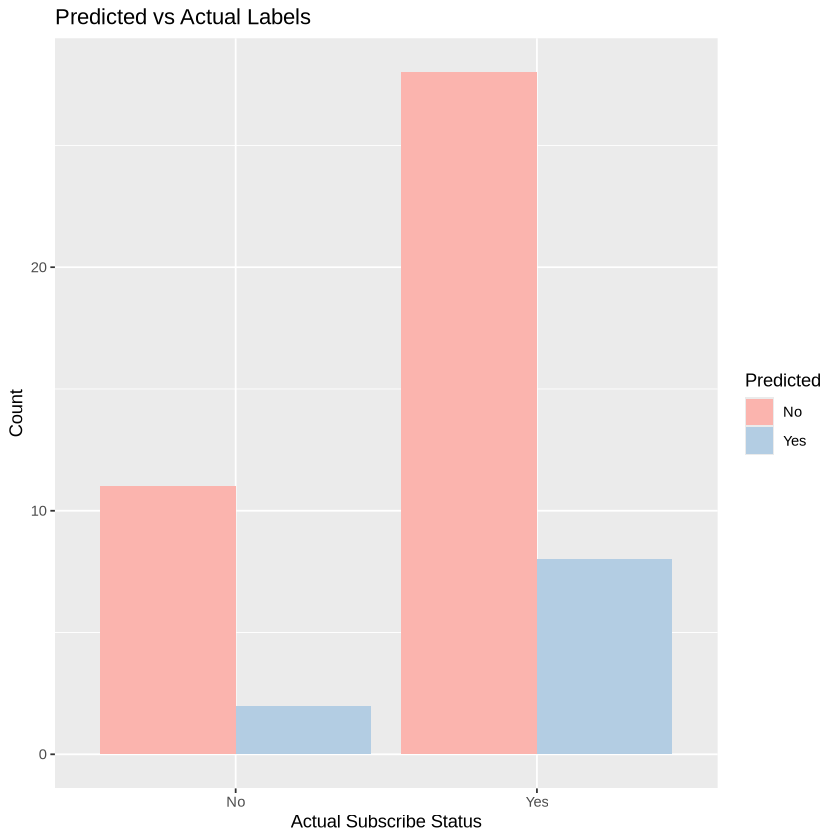

In [44]:
# to choose the best K-value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

# To see how well our model predict the class
predictions_plot <- players_test_predictions |>
    count(subscribe, .pred_class) |>
    ggplot(aes(x = subscribe, y = n, fill = .pred_class)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_brewer(palette = "Pastel1") +
    labs(x = "Actual Subscribe Status", y = "Count", fill = "Predicted") +
    ggtitle("Predicted vs Actual Labels")

predictions_plot

## **III. Discussion**

**Summary of what we found**

From the results, we found that our KNN classification model has an accuracy of around 39% using the most accurate k-value of 7. We evaluated a k-nn model to predict subscription status. The overall model accuracy was 39%, with the highest performance at k = 7. Despite this, the model shows a clear bias toward predicting "No," including many incorrect "No" predictions for actual "Yes" cases. This indicates that while k = 7 offers the best performance among tested values, the model still struggles to identify subscribers correctly and may require further tuning or feature engineering to improve its predictive power.

**Whether this is what we expected to find**

This is not what we expected to find, as we expected our model accuracy to be higher.

**What impact could our findings have**

Our findings suggest that using this k-nn model in its current state to predict subscription behavior would likely lead to missed opportunities, especially in identifying potential subscribers. With a 41% accuracy and a strong bias toward predicting non-subscription, businesses relying on this model might fail to engage interested users, leading to inefficient marketing efforts and lost revenue. These results highlight the importance of improving model accuracy and balance before deploying predictive tools to help with consumer applications.

**Future questions this lead to**

To improve our model's performance, future questions that can be asked include whether accuracy would improve by adding additional predictor variables or gaining data to help capture more relevant patterns.

## **References**

Timbers, T., Campbell, T., & Lee, M. (2024). *Chapter 5 Classification I: training & predicting*. In *Data Science: A First Introduction*. https://datasciencebook.ca/classification1.html 

Timbers, T., Campbell, T., & Lee, M. (2024). *Chapter 6 Classification II: evaluation & tuning*. In *Data Science: A First Introduction*. https://datasciencebook.ca/classification2.html
